# Demonstration of Measuring the Thickness of a Tepal in a Lily Slice Image

Masks of lily slice images were made by hand in photoshop. We'll start by importing one of these masks.


In [110]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.util import img_as_bool, img_as_ubyte
from skimage.morphology import erosion as erode
from skimage.morphology import closing
from skimage.morphology import dilation as dilate
from skimage.morphology import skeletonize
from skimage.morphology import disk

from scipy.ndimage import label as scipylabel
from skimage.morphology import label as morphlabel
from skimage.measure import regionprops_table, regionprops

from sklearn.neighbors import NearestNeighbors
import networkx as nx

from scipy.spatial.distance import euclidean

from google.colab import drive    # Code required to access files in google drive

drive.mount('/content/drive', force_remount=True)   # Mount google drive in order to access files

Mounted at /content/drive


(-0.5, 1599.5, 1199.5, -0.5)

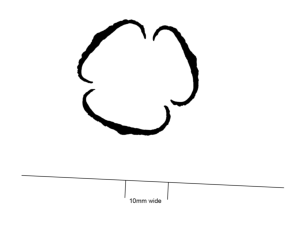

In [115]:
im = img_as_ubyte(plt.imread('/content/drive/MyDrive/LilyData/lilymask.jpeg'))

plt.imshow(im, cmap='gray')
plt.axis('off')

To measure the thickness, we'll first need to isolate each tepal in an image using the `separate_tepals()` function.

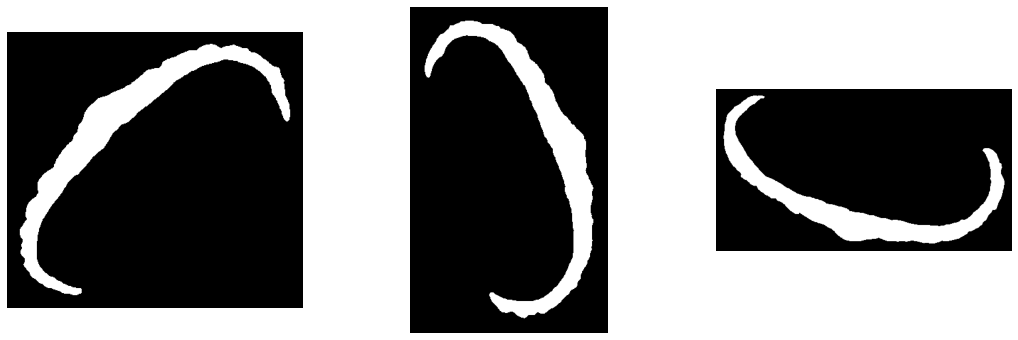

In [116]:
im_tep1, im_tep2, im_tep3 = separate_tepals(im)

fig, ax = plt.subplots(ncols=3, figsize=(18,6))

ax[0].imshow(im_tep1, cmap='gray')
ax[1].imshow(im_tep2, cmap='gray')
ax[2].imshow(im_tep3, cmap='gray')

for axi in ax:
  axi.axis('off')

Next, we need to obtain skeletons for each of these images, extract their coordinates, and reorder them so that they are listed end to end of the skeleton. This is required in order to calculate directional vectors at every pixel coordinate along the skeleton. To reorder the coordinates, we'll use the `reorder_skeleton()` function.

In [117]:
im_teps = [im_tep1, im_tep2, im_tep3]

# Skeletonize each tepal and 
skel_coords = []
for i, tepal in enumerate(im_teps):
  im_tepal = (im_teps[i]/255).astype(int)
  tep_skel = skeletonize(im_tepal)
  tep_skelcoord = np.argwhere(tep_skel)
  skel_ord = reorder_skeleton(tep_skelcoord)
  skel_coords.append(skel_ord)

If we plot the points in the order they are listed, we can show how the points are correctly reordered so that they are connected to their nearest two neighbors.

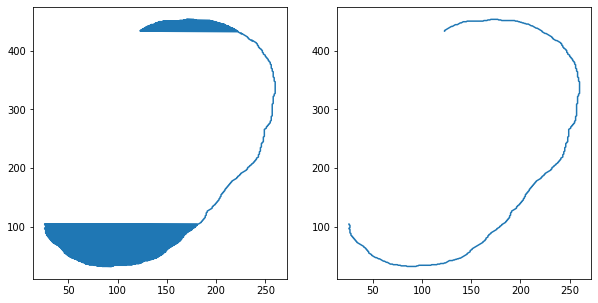

In [118]:
test = skel_coords[1]
unordered = np.argwhere(skeletonize((im_teps[1]/255).astype(int)))

fig, ax = plt.subplots(ncols=2, figsize=(10,5))

ax[0].plot(unordered[:,1], unordered[:,0])
ax[1].plot(test[:,1], test[:,0])

Now that we have the correct order of skeleton coordinates, we can measure thickness. We just need to input our original tepal images from the `im_teps` array, along with their corresponding lists of ordered skeleton coordinates in the `skel_coords` array.

In [119]:
thickness_measurements = []

for j, tepals in enumerate(im_teps):
  thickness = measure_thickness(im_teps[j], skel_coords[j])
  thickness_measurements.append(thickness)

Finally, we can plot our results against the model for each of the three tepals in our slice image.

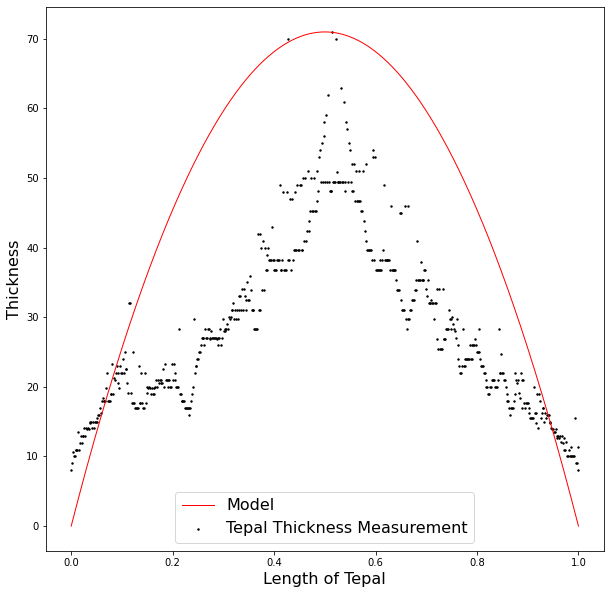

In [120]:
# Tepal 1
plot_thickness_vs_width(thickness_measurements[0], figuresize=(10,10), show_model='true')

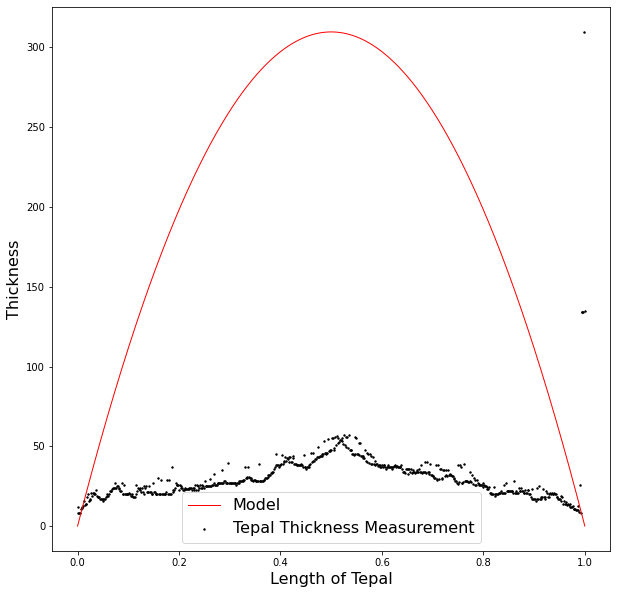

In [121]:
# Tepal 2
plot_thickness_vs_width(thickness_measurements[1], figuresize=(10,10), show_model='true')

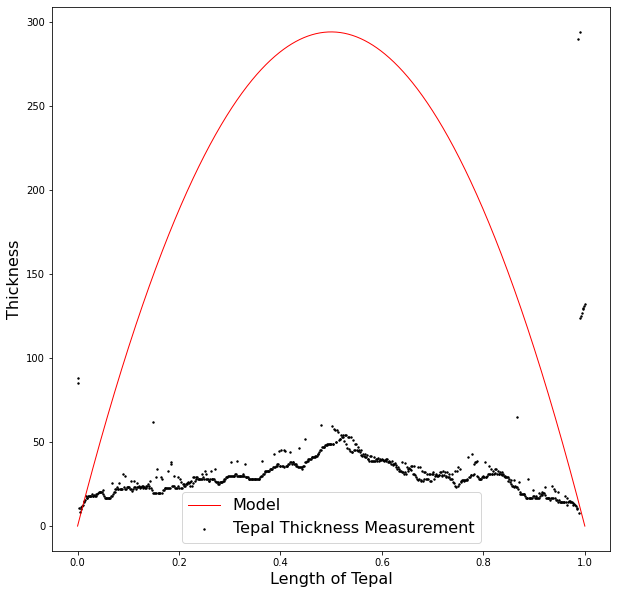

In [122]:
# Tepal 3
plot_thickness_vs_width(thickness_measurements[2], figuresize=(10,10), show_model='true')

*Below are the functions demonstrated in this notebook:*

In [111]:
def separate_tepals(im):
  
  # Remove scale bar and scale text
  im_c = closing(im, disk(4))

  # Ensure no data is lost in the closing step by enlarging im_c and performing boolean logic with original image to isolate tepals
  im_c_overlap = erode(im_c, disk(7))
  im_bool = img_as_bool(im)
  im_teps = np.invert(np.logical_and(np.invert(im_bool), np.invert(im_c_overlap)))

  # Label tepals
  label_teps, _ = scipylabel(np.invert(im_teps))

  # Isolate tepals
  tepals = []

  for tepal in regionprops(label_teps):
    crop = np.pad(tepal.image, np.round(0.05*len(tepal.image)).astype(int))
    tepals.append(crop)

  # Save tepals
  tepal1 = img_as_ubyte(tepals[0])
  tepal2 = img_as_ubyte(tepals[1])
  tepal3 = img_as_ubyte(tepals[2])

  return tepal1, tepal2, tepal3

In [112]:
def reorder_skeleton(skel_coord):

  # Run NearestNeighbors algorithm for nearest 2 points and create sparse matrix relating points
  skel_NN = NearestNeighbors(2).fit(skel_coord)
  skel_sparse = skel_NN.kneighbors_graph()

  # Generate network from sparse matrix
  skel_net = nx.from_scipy_sparse_matrix(skel_sparse)
  
  # Obtain all possible paths starting at each point that pass through all points on the skeleton once
  skel_paths = [list(nx.dfs_preorder_nodes(skel_net, i)) for i in range(len(skel_coord))]

  # Cost function to determine the shortest path through the points which will be endpoint to endpoint
  min_dist = np.inf
  skel_initx = 0
  
  for i in range(len(skel_coord)):

    p = skel_paths[i]
    skel_ordered = skel_coord[p]

    cost = (((skel_ordered[:-1] - skel_ordered[1:])**2).sum(1)).sum()

    if cost < min_dist:
      min_dist = cost
      skel_initx = i
    
  # Obtain optimal index order of 
  skel_optord = skel_paths[skel_initx]

  # Reorder skeleton using the optimal index order
  x = skel_coord[:,1]
  y = skel_coord[:,0]
  
  skel_end2end = skel_coord

  skel_end2end[:,1] = x[skel_optord]
  skel_end2end[:,0] = y[skel_optord]

  return skel_end2end

In [113]:
def measure_thickness(im, im_skelcoords):
  
  # Get vectors tangent to skeleton
  tangent_vecs = np.diff(im_skelcoords, n=1, axis=0)
  
  # Calculate perpendicular vectors from tangent vectors
  ortho_vecs = tangent_vecs[:, ::-1]
  ortho_vecs[:,1] = -ortho_vecs[:,1]

  # Obtain outline of tepal image
  im_outline = np.logical_xor(im, erode(im, disk(1)))


  # Define thickness_data array
  thickness_data = []

  # Loop through orthogonal vectors along skeleton and measure thickness
  for i, coordinates in enumerate(ortho_vecs):

    if i > len(ortho_vecs) - 1:
      break

    # Create an empty array of 0s to image with cross-section lines
    im_l = np.zeros(np.shape(im_outline)) > 0.5 

    # Create grid of xy coordinates for Boolean operations
    xi = np.linspace(0, np.shape(im_outline)[1]-1, np.shape(im_outline)[1])
    yi = np.linspace(0, np.shape(im_outline)[0]-1, np.shape(im_outline)[0])
    y, x = np.meshgrid(xi, yi)

    # If the perpendicular vectors are vertical, draw vertical line at x coordinate of the skeleton
    if ortho_vecs[i,0] == 0: 
      im_l[x == im_skelcoords[i+1,0]] = True

    # Calculate slope, m, and intercept, b, of perpendicular line
    else:
      m = ortho_vecs[i,1]/ortho_vecs[i,0] 
      b = im_skelcoords[i,1] - m*im_skelcoords[i,0]

      # Draw perpendicular line in binary image (when not vertical)
      im_l[np.abs(y - (m*x + b)) < 0.5] = True 

    # Find intersections of tepal outline with perpendicular line
    im_i = dilate(im_outline, disk(3)) & im_l

    # Label intersection points
    im_il = morphlabel(im_i)
    #print(type(im_il))

    # Find centroids of intersection points
    regions = regionprops_table(im_il, properties=('label','centroid')) 

    # Organize intersection centroid coordinates into an array
    for j, centroid_coords in enumerate(regions.values()):
      if j == 0:
        x_pts = centroid_coords
      else:
        x_pts = np.vstack((x_pts, centroid_coords))

    # List intersection points as pairs of x and y coordinates
    x_pts = np.transpose(x_pts[1:,:])

    # If perpenicular vector crosses tepal outline in more than two places, only pick out the two closest points to the current skeleton coordinate 
    if len(x_pts) > 2:
      test_dists = []

      for row in x_pts:
        add_dist = np.round(euclidean(row, im_skelcoords[i]), 3)
        test_dists.append(add_dist)

      while len(x_pts) > 2:
        max_dist = np.max(test_dists)
        kill_index = test_dists.index(max_dist)
        x_pts = np.delete(x_pts, kill_index, axis=0)
        del test_dists[kill_index]
    
    # Save point 1 and point 2 for end bounds of thickness measurement
    p1 = x_pts[0]
    p2 = x_pts[1]

    # Calculate distance between intersection points in pixels
    dist = euclidean(p1, p2)
    
    # Add dist measurement to thickness array
    thickness_data.append(dist)

  return thickness_data

In [114]:
def plot_thickness_vs_width(thickness_data, figuresize, show_model='false'):

  size = np.size(thickness_data)
  
  x = np.linspace(0,1,size)
  
  fig, ax = plt.subplots(figsize= figuresize)
  
  ax.scatter(x, thickness_data, c='#000000', s=2, label='Tepal Thickness Measurement')
  plt.xlabel('Length of Tepal', fontsize=16)
  plt.ylabel('Thickness', fontsize=16)
  
  if show_model == 'true':
    y = np.linspace(0,1,1001)
    model = np.max(thickness_data)*(1 - (y - 0.5)**2/(0.25))
    ax.plot(y, model, c='#FF0000', linewidth=1, label='Model')
    ax.legend(fontsize=16)

  else:
    return

  return